<a href="https://colab.research.google.com/github/11jolek11/BigDataHCVproject/blob/SMOTE/BigDataHCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
!pip install -q imbalanced-learn

import matplotlib.pyplot as plt

In [155]:
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced

# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN

# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost
from sklearn.ensemble import AdaBoostClassifier

# Data preparation


In [156]:
hcv = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/hcvdat0.csv', header=0)
hcv[hcv.isna().any(axis=1)]
print()

In [157]:
np.unique(hcv["Category"])

array(['0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis',
       '2=Fibrosis', '3=Cirrhosis'], dtype=object)

<Axes: xlabel='Category', ylabel='count'>

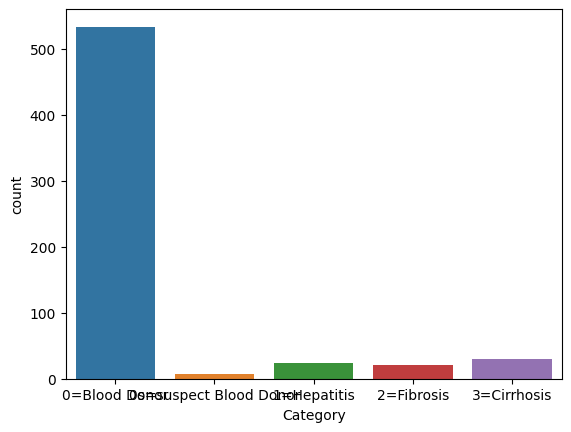

In [158]:
sns.countplot(x=hcv["Category"])

In [159]:
hcv.replace('1=Hepatitis', '1=HCV', inplace=True)
hcv.replace('2=Fibrosis', '1=HCV', inplace=True)
hcv.replace('3=Cirrhosis', '1=HCV', inplace=True)

In [160]:
hcv["Category"].value_counts()

0=Blood Donor             533
1=HCV                      75
0s=suspect Blood Donor      7
Name: Category, dtype: int64

In [161]:
hcv.drop(hcv[hcv["Category"] == '0s=suspect Blood Donor'].index, inplace=True)

In [162]:
hcv["Category"].value_counts()

0=Blood Donor    533
1=HCV             75
Name: Category, dtype: int64

<Axes: xlabel='Category', ylabel='count'>

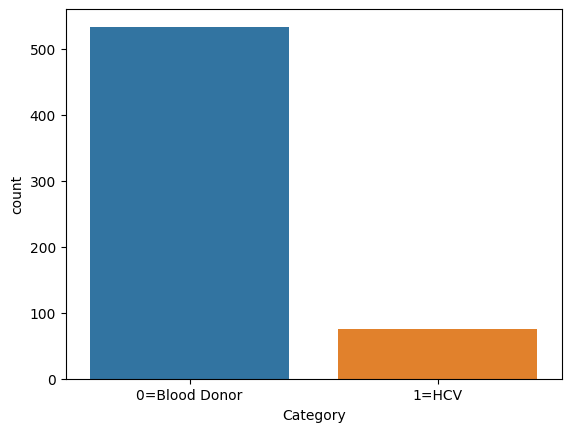

In [163]:
sns.countplot(x=hcv["Category"])

<ipython-input-164-7703969109d3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hcv.corr(), annot=True, cmap='rainbow')


<Axes: >

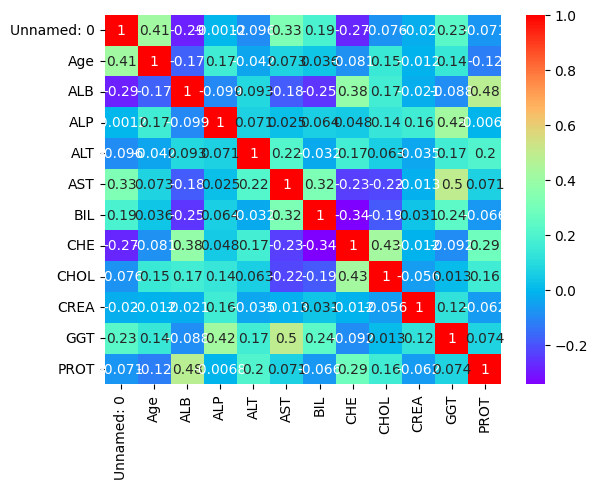

In [164]:
sns.heatmap(hcv.corr(), annot=True, cmap='rainbow')

In [165]:
encoder = LabelEncoder()
hcv["Sex"] = encoder.fit_transform(hcv["Sex"])
hcv["Category"] = encoder.fit_transform(hcv["Category"])
classes = encoder.classes_
encoded_classes = encoder.transform(classes)
original_encoded_dict = dict(zip(classes, encoded_classes))
print(original_encoded_dict)

{'0=Blood Donor': 0, '1=HCV': 1}


In [166]:
print(encoder.get_params(deep=True))

{}


In [167]:
imputer = IterativeImputer(max_iter=10, random_state=0).set_output(transform="pandas")
hcv = imputer.fit_transform(hcv)
hcv[hcv.isna().any(axis=1)]

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT


In [168]:
hcv.shape

(608, 14)

In [169]:
hcv_target = hcv["Category"]
hcv.drop(columns=["Category"], inplace=True)

#PCA n=2

In [170]:
pca_pipeline = Pipeline(
    [
      ('scaler', StandardScaler()),
      ('pca_dim_reduction', PCA(n_components=2)),
    ]
)

hcv_pca = pd.DataFrame(pca_pipeline.fit_transform(hcv), columns = ['pca1', 'pca2'])

In [171]:
std_scaler = StandardScaler()

smote = SMOTE()
adasyn = ADASYN()
smoteenn = SMOTEENN()

In [172]:
x_train, x_test, y_train, y_test = train_test_split(hcv_pca, hcv_target, stratify=hcv_target)

x_train = std_scaler.fit_transform(x_train)
x_test = std_scaler.transform(x_test)

X_train_smt, Y_train_smt = smote.fit_resample(x_train, y_train)
X_train_ada, Y_train_ada = adasyn.fit_resample(x_train, y_train)
X_train_enn, Y_train_enn = smoteenn.fit_resample(x_train, y_train)

In [173]:
print(X_train_smt.shape)
print(X_train_ada.shape)
print(X_train_enn.shape)
print()

print(Y_train_smt.shape)
print(Y_train_ada.shape)
print(Y_train_enn.shape)
print()


temp, count = np.unique(Y_train_smt, return_counts=True)
print(np.asarray((temp, count)).T)
print()

temp, count = np.unique(Y_train_ada, return_counts=True)
print(np.asarray((temp, count)).T)
print()

temp, count = np.unique(Y_train_enn, return_counts=True)
print(np.asarray((temp, count)).T)
print()

(800, 2)
(803, 2)
(626, 2)

(800,)
(803,)
(626,)

[[  0. 400.]
 [  1. 400.]]

[[  0. 400.]
 [  1. 403.]]

[[  0. 306.]
 [  1. 320.]]



<Axes: xlabel='pca1', ylabel='pca2'>

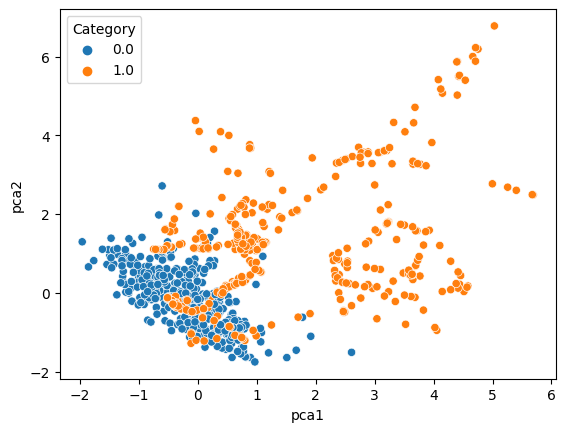

In [174]:
temp = pd.DataFrame(X_train_smt, columns=['pca1', 'pca2'])
sns.scatterplot(data=temp, x="pca1", y="pca2", hue=Y_train_smt)

<Axes: xlabel='pca1', ylabel='pca2'>

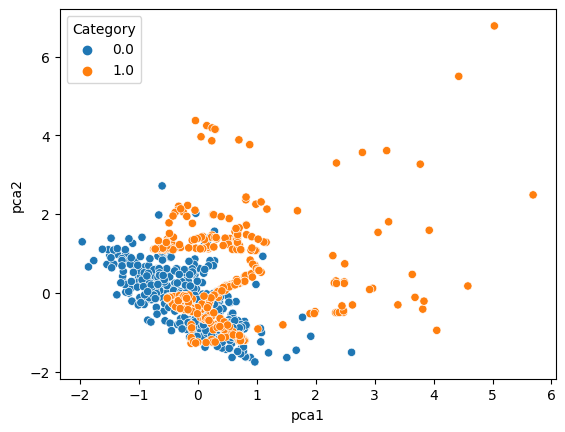

In [175]:
temp = pd.DataFrame(X_train_ada, columns=['pca1', 'pca2'])
sns.scatterplot(data=temp, x="pca1", y="pca2", hue=Y_train_ada)

<Axes: xlabel='pca1', ylabel='pca2'>

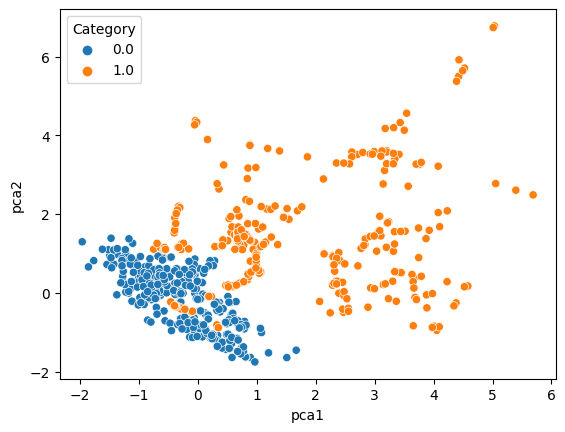

In [176]:
temp = pd.DataFrame(X_train_enn, columns=['pca1', 'pca2'])
sns.scatterplot(data=temp, x="pca1", y="pca2", hue=Y_train_enn)

# Models (report generator)


In [177]:
def generate(X_train_enn, Y_train_enn, x_test, y_test):

  rfc = RandomForestClassifier()
  print(rfc.__class__.__name__)
  params = {"max_depth": (3, 4, 5, 6)}
  grid = GridSearchCV(rfc, params)
  grid.fit(X_train_enn, Y_train_enn)
  Y_train_enn_predict = grid.best_estimator_.predict(x_test)
  Y_train_enn_predict_proba = grid.best_estimator_.predict_proba(x_test)

  report = classification_report(y_test, Y_train_enn_predict)
  print(report)
  report = classification_report(y_test, Y_train_enn_predict, output_dict=True)

  cm = confusion_matrix(y_test, Y_train_enn_predict, labels=grid.best_estimator_.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.best_estimator_.classes_)
  disp.plot()
  plt.show()

  fpr = {}
  tpr = {}
  thresh ={}

  n_class = Y_train_enn_predict_proba.shape[1]

  for i in range(n_class):
      fpr[i], tpr[i], thresh[i] = roc_curve(Y_train_enn_predict, Y_train_enn_predict_proba[:,i], pos_label=i)

  # plotting
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Class 0')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')

  plt.show()

  knn = KNeighborsClassifier()

  print(knn.__class__.__name__)
  params = {"n_neighbors": tuple([i for i in range(1, 7)])}
  grid = GridSearchCV(knn, params)
  grid.fit(X_train_enn, Y_train_enn)
  Y_train_enn_predict = grid.best_estimator_.predict(x_test)
  Y_train_enn_predict_proba = grid.best_estimator_.predict_proba(x_test)

  report = classification_report(y_test, Y_train_enn_predict)
  print(report)
  report = classification_report(y_test, Y_train_enn_predict, output_dict=True)

  cm = confusion_matrix(y_test, Y_train_enn_predict, labels=grid.best_estimator_.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.best_estimator_.classes_)
  disp.plot()
  plt.show()

  fpr = {}
  tpr = {}
  thresh ={}

  n_class = Y_train_enn_predict_proba.shape[1]

  for i in range(n_class):
      fpr[i], tpr[i], thresh[i] = roc_curve(Y_train_enn_predict, Y_train_enn_predict_proba[:,i], pos_label=i)

  # plotting
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Class 0')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')

  plt.show()

  # params={'C':np.logspace(-10, 1, 15)}
  svc = SVC()
  print(svc.__class__.__name__)
  params={'C': (1, 2, 3), "kernel": ('linear', 'poly', 'rbf', 'sigmoid')}
  grid = GridSearchCV(svc, params)
  grid.fit(X_train_enn, Y_train_enn)
  Y_train_enn_predict = grid.best_estimator_.predict(x_test)

  report = classification_report(y_test, Y_train_enn_predict)
  print(report)
  report = classification_report(y_test, Y_train_enn_predict, output_dict=True)

  cm = confusion_matrix(y_test, Y_train_enn_predict, labels=grid.best_estimator_.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.best_estimator_.classes_)
  disp.plot()
  plt.show()

  dtc = DecisionTreeClassifier()

  print(dtc.__class__.__name__)
  params={"max_depth": tuple([i for i in range(1, 10)])}
  grid = GridSearchCV(dtc, params)
  grid.fit(X_train_enn, Y_train_enn)
  Y_train_enn_predict = grid.best_estimator_.predict(x_test)
  Y_train_enn_predict_proba = grid.best_estimator_.predict_proba(x_test)

  report = classification_report(y_test, Y_train_enn_predict)
  print(report)
  report = classification_report(y_test, Y_train_enn_predict, output_dict=True)

  cm = confusion_matrix(y_test, Y_train_enn_predict, labels=grid.best_estimator_.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.best_estimator_.classes_)
  disp.plot()
  plt.show()

  fpr = {}
  tpr = {}
  thresh ={}

  n_class = Y_train_enn_predict_proba.shape[1]

  for i in range(n_class):
      fpr[i], tpr[i], thresh[i] = roc_curve(Y_train_enn_predict, Y_train_enn_predict_proba[:,i], pos_label=i)

  # plotting
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Class 0')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')

  plt.show()

  print("Bayes")
  gnb = GaussianNB()
  gnb.fit(X_train_enn, Y_train_enn)
  Y_train_enn_predict = gnb.predict(x_test)
  Y_train_enn_predict_proba = grid.best_estimator_.predict_proba(x_test)

  report = classification_report(y_test, Y_train_enn_predict)
  print(report)
  report = classification_report(y_test, Y_train_enn_predict, output_dict=True)

  cm = confusion_matrix(y_test, Y_train_enn_predict, labels=grid.best_estimator_.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.best_estimator_.classes_)
  disp.plot()
  plt.show()


  fpr = {}
  tpr = {}
  thresh ={}

  n_class = Y_train_enn_predict_proba.shape[1]

  for i in range(n_class):
      fpr[i], tpr[i], thresh[i] = roc_curve(Y_train_enn_predict, Y_train_enn_predict_proba[:,i], pos_label=i)

  # plotting
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Class 0')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')

  plt.show()


  xgb_c = xgboost.XGBClassifier()
  print(xgb_c.__class__.__name__)
  xgb_c.fit(X_train_enn, Y_train_enn)
  Y_train_enn_predict = xgb_c.predict(x_test)
  Y_train_enn_predict_proba = grid.best_estimator_.predict_proba(x_test)

  report = classification_report(y_test, Y_train_enn_predict)
  print(report)
  report = classification_report(y_test, Y_train_enn_predict, output_dict=True)

  cm = confusion_matrix(y_test, Y_train_enn_predict, labels=grid.best_estimator_.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.best_estimator_.classes_)
  disp.plot()
  plt.show()


  fpr = {}
  tpr = {}
  thresh ={}

  n_class = Y_train_enn_predict_proba.shape[1]

  for i in range(n_class):
      fpr[i], tpr[i], thresh[i] = roc_curve(Y_train_enn_predict, Y_train_enn_predict_proba[:,i], pos_label=i)

  # plotting
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Class 0')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.show()

  adab_c = AdaBoostClassifier()
  print(adab_c.__class__.__name__)
  params={"n_estimators": tuple([i for i in range(50, 300, 50)])}
  grid = GridSearchCV(adab_c, params)
  grid.fit(X_train_enn, Y_train_enn)
  Y_train_enn_predict = grid.best_estimator_.predict(x_test)
  Y_train_enn_predict_proba = grid.best_estimator_.predict_proba(x_test)
  report = classification_report(y_test, Y_train_enn_predict)
  print(report)
  report = classification_report(y_test, Y_train_enn_predict, output_dict=True)

  cm = confusion_matrix(y_test, Y_train_enn_predict, labels=grid.best_estimator_.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.best_estimator_.classes_)
  disp.plot()
  plt.show()


  fpr = {}
  tpr = {}
  thresh ={}

  n_class = Y_train_enn_predict_proba.shape[1]

  for i in range(n_class):
      fpr[i], tpr[i], thresh[i] = roc_curve(Y_train_enn_predict, Y_train_enn_predict_proba[:,i], pos_label=i)

  # plotting
  plt.plot(fpr[0], tpr[0], linestyle='--',color='blue', label='Class 0')
  plt.title('ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc='best')
  plt.show()


In [178]:
print(x_test.shape)
print(y_test.shape)

(152, 2)
(152,)


RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       133
         1.0       0.62      0.68      0.65        19

    accuracy                           0.91       152
   macro avg       0.79      0.81      0.80       152
weighted avg       0.91      0.91      0.91       152



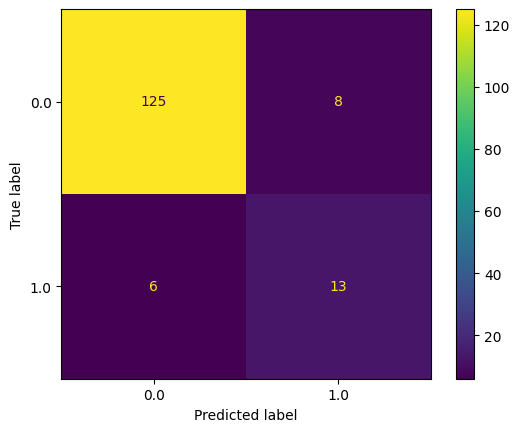

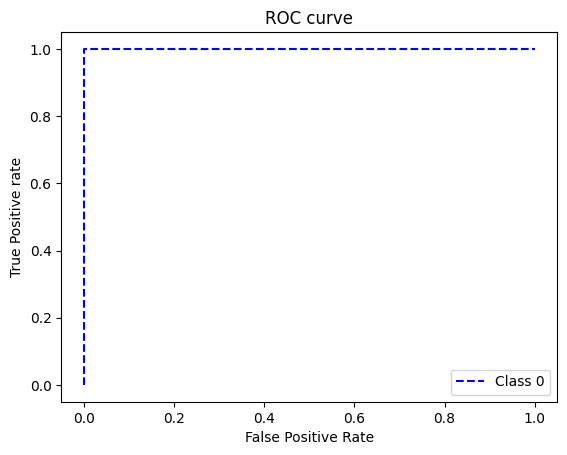

KNeighborsClassifier
              precision    recall  f1-score   support

         0.0       0.97      0.90      0.93       133
         1.0       0.54      0.79      0.64        19

    accuracy                           0.89       152
   macro avg       0.75      0.85      0.79       152
weighted avg       0.91      0.89      0.90       152



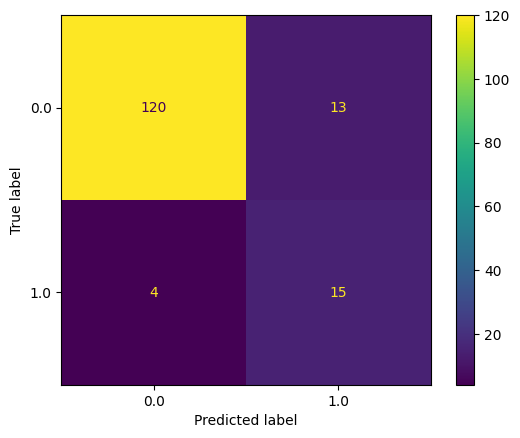

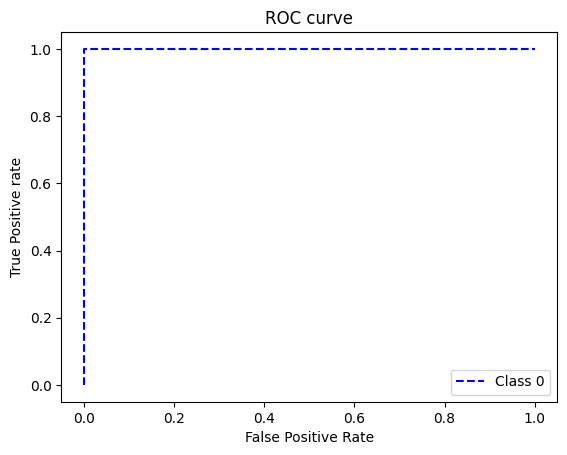

SVC
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       133
         1.0       0.76      0.68      0.72        19

    accuracy                           0.93       152
   macro avg       0.86      0.83      0.84       152
weighted avg       0.93      0.93      0.93       152



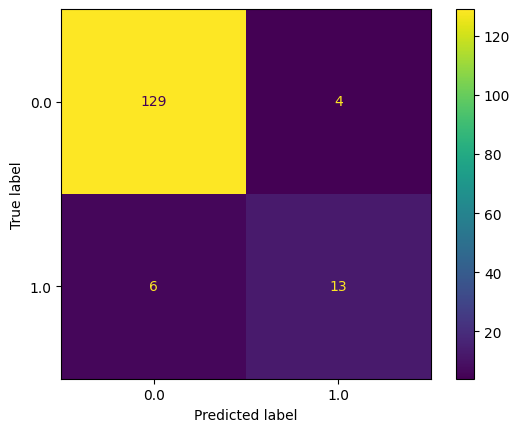

DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94       133
         1.0       0.60      0.63      0.62        19

    accuracy                           0.90       152
   macro avg       0.77      0.79      0.78       152
weighted avg       0.90      0.90      0.90       152



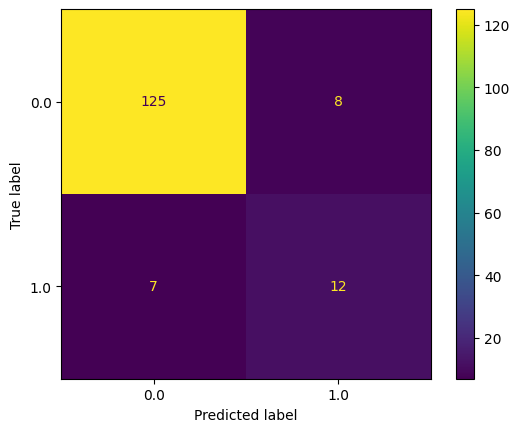

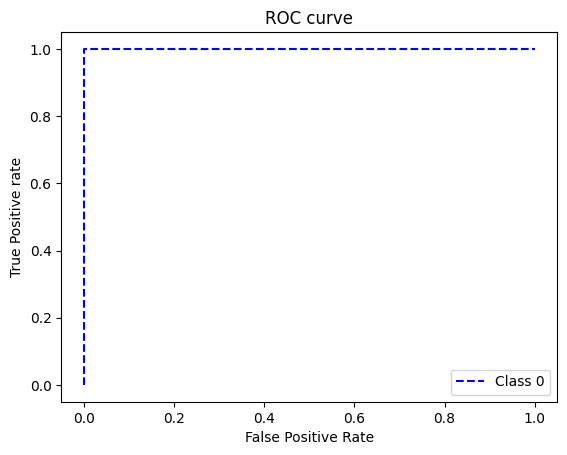

Bayes
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       133
         1.0       0.67      0.63      0.65        19

    accuracy                           0.91       152
   macro avg       0.81      0.79      0.80       152
weighted avg       0.91      0.91      0.91       152



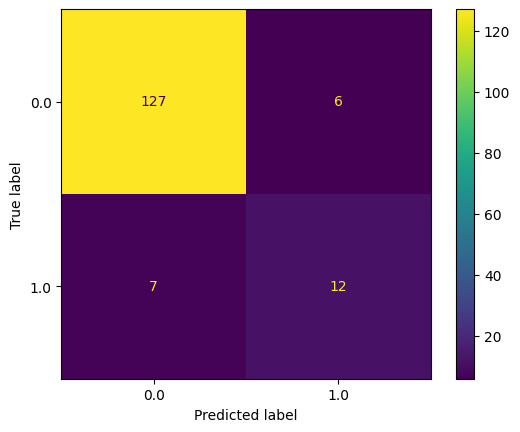

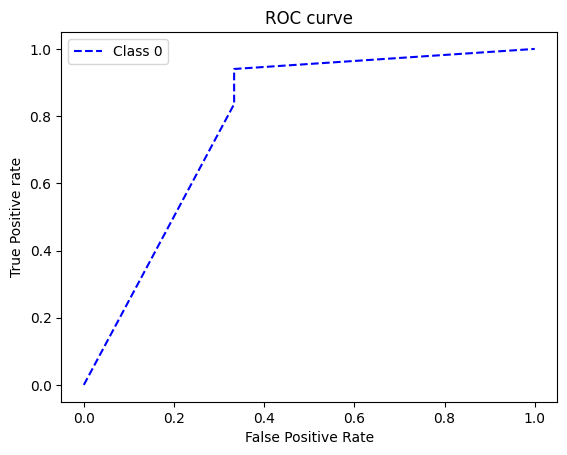

XGBClassifier
              precision    recall  f1-score   support

         0.0       0.94      0.91      0.92       133
         1.0       0.48      0.58      0.52        19

    accuracy                           0.87       152
   macro avg       0.71      0.74      0.72       152
weighted avg       0.88      0.87      0.87       152



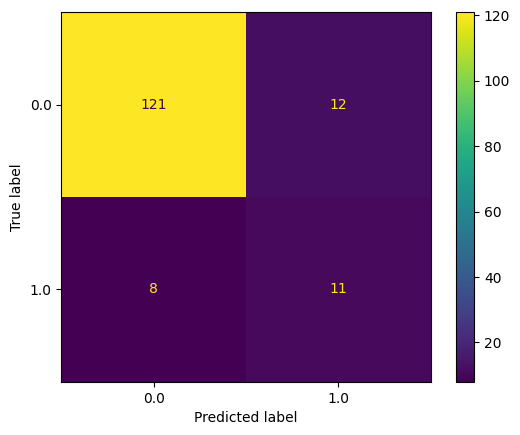

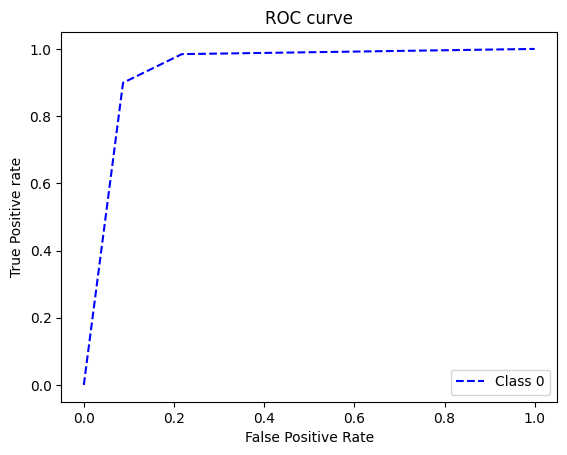

AdaBoostClassifier
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93       133
         1.0       0.54      0.74      0.62        19

    accuracy                           0.89       152
   macro avg       0.75      0.82      0.78       152
weighted avg       0.91      0.89      0.90       152



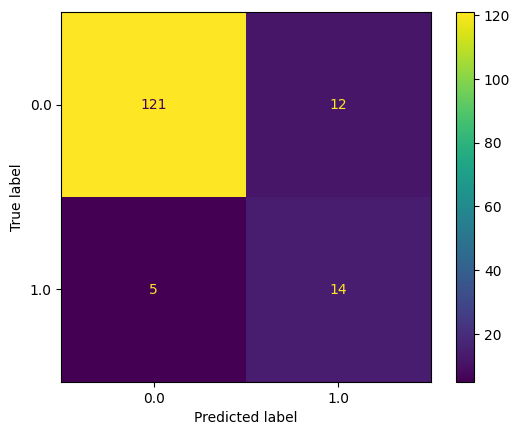

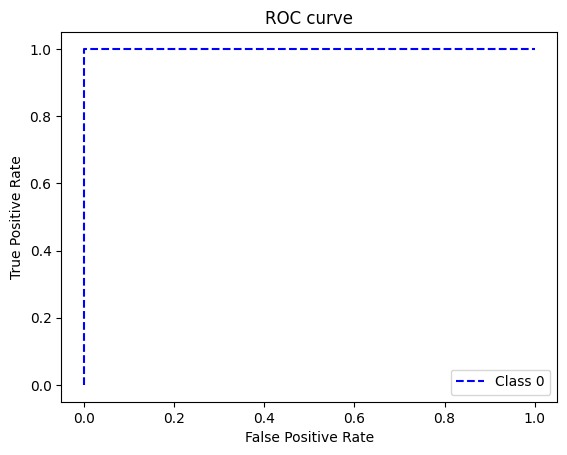

In [179]:
generate(X_train_enn, Y_train_enn, x_test, y_test)

RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       133
         1.0       0.76      0.68      0.72        19

    accuracy                           0.93       152
   macro avg       0.86      0.83      0.84       152
weighted avg       0.93      0.93      0.93       152



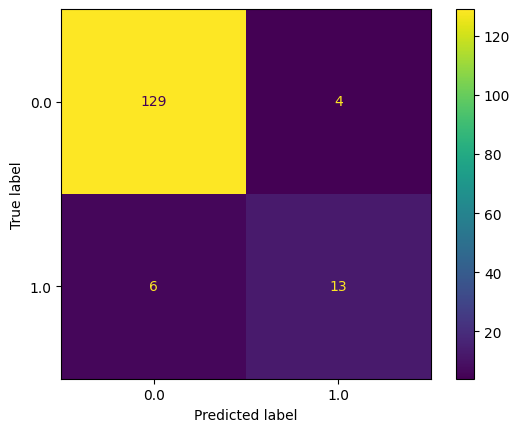

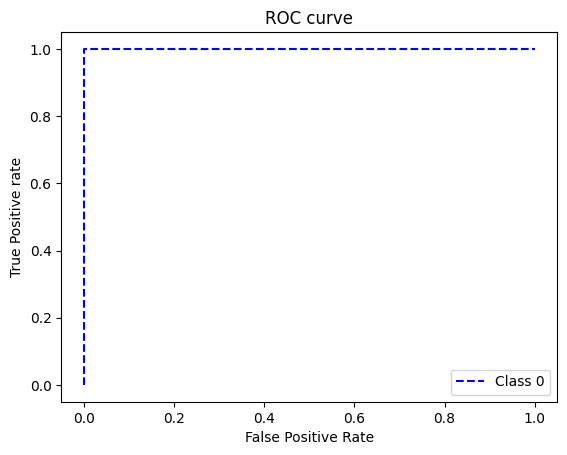

KNeighborsClassifier
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94       133
         1.0       0.56      0.79      0.65        19

    accuracy                           0.89       152
   macro avg       0.76      0.85      0.80       152
weighted avg       0.92      0.89      0.90       152



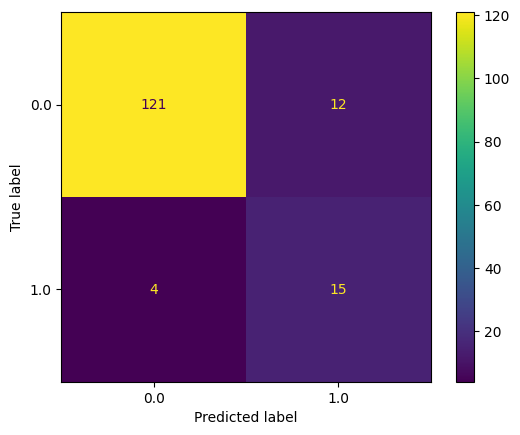

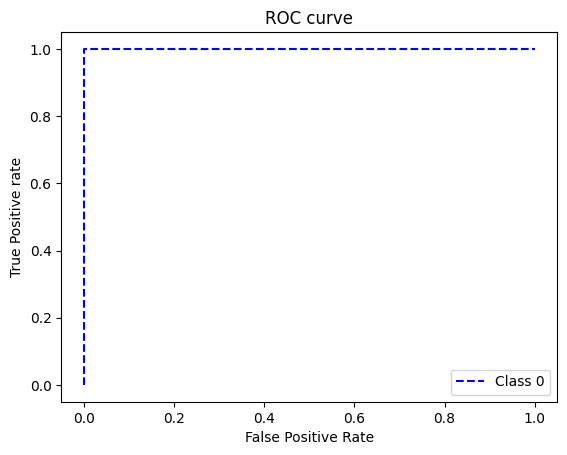

SVC
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       133
         1.0       0.76      0.68      0.72        19

    accuracy                           0.93       152
   macro avg       0.86      0.83      0.84       152
weighted avg       0.93      0.93      0.93       152



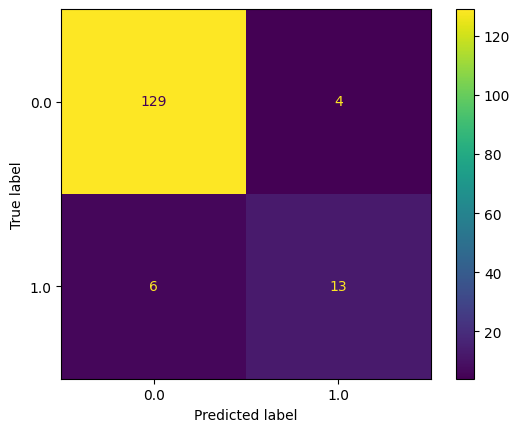

DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       133
         1.0       0.63      0.63      0.63        19

    accuracy                           0.91       152
   macro avg       0.79      0.79      0.79       152
weighted avg       0.91      0.91      0.91       152



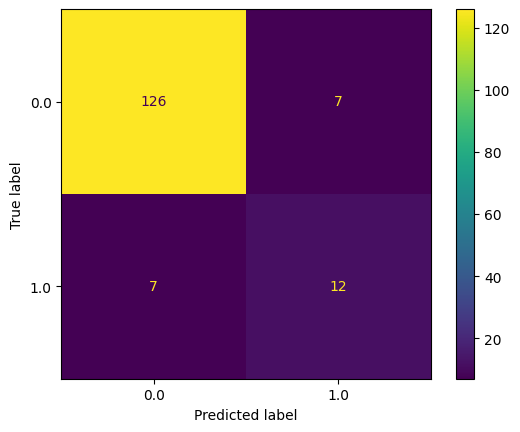

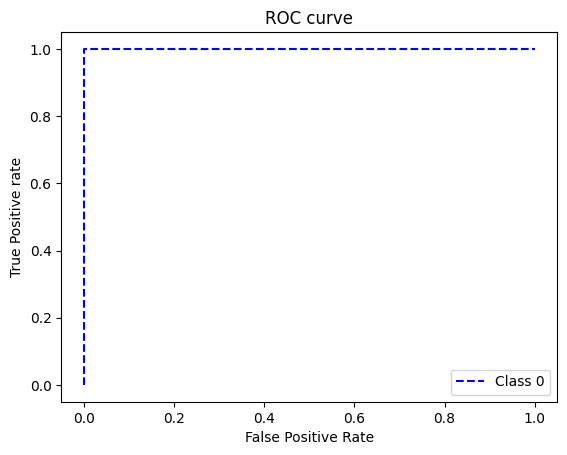

Bayes
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       133
         1.0       0.61      0.58      0.59        19

    accuracy                           0.90       152
   macro avg       0.78      0.76      0.77       152
weighted avg       0.90      0.90      0.90       152



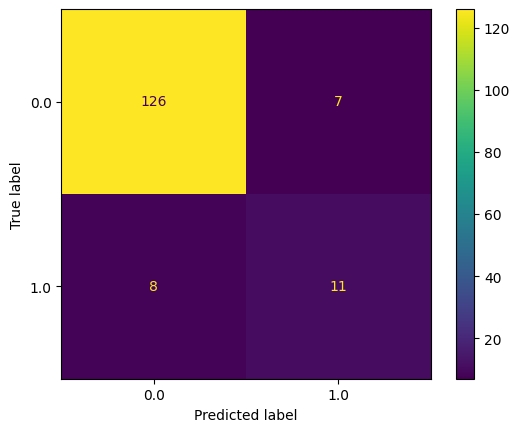

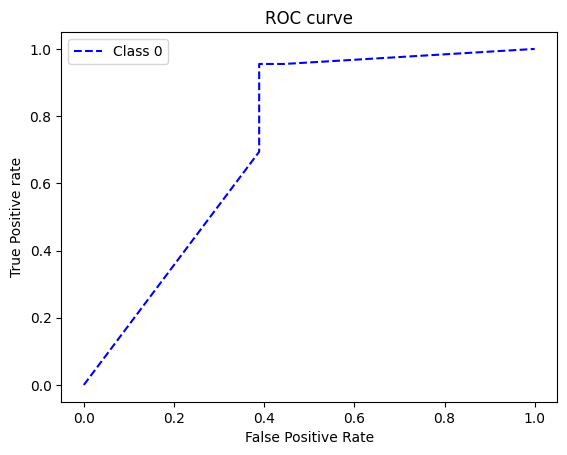

XGBClassifier
              precision    recall  f1-score   support

         0.0       0.97      0.94      0.95       133
         1.0       0.65      0.79      0.71        19

    accuracy                           0.92       152
   macro avg       0.81      0.86      0.83       152
weighted avg       0.93      0.92      0.92       152



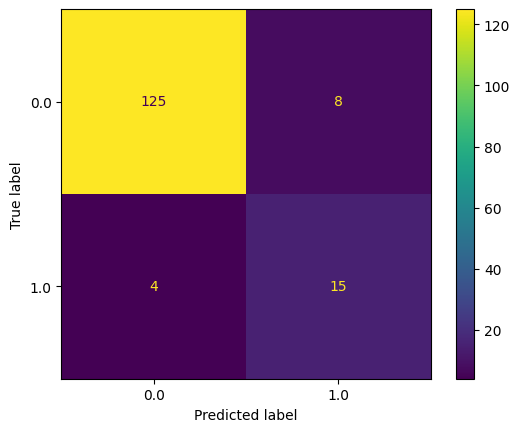

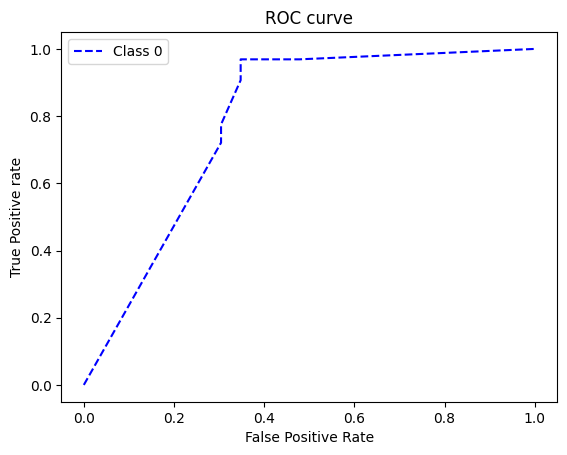

AdaBoostClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93       133
         1.0       0.52      0.63      0.57        19

    accuracy                           0.88       152
   macro avg       0.73      0.77      0.75       152
weighted avg       0.89      0.88      0.89       152



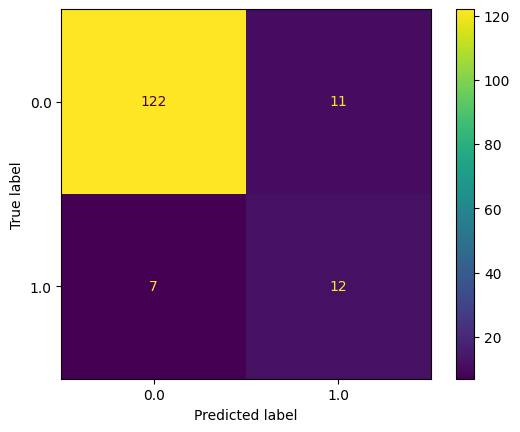

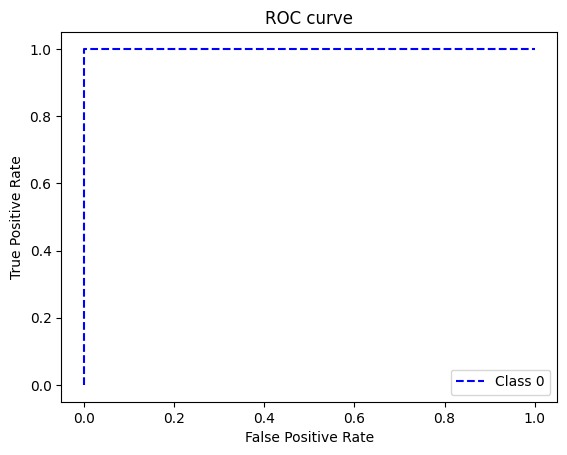

In [180]:
generate(X_train_smt, Y_train_smt, x_test, y_test)

RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.83      0.89       133
         1.0       0.37      0.68      0.48        19

    accuracy                           0.82       152
   macro avg       0.66      0.76      0.68       152
weighted avg       0.88      0.82      0.84       152



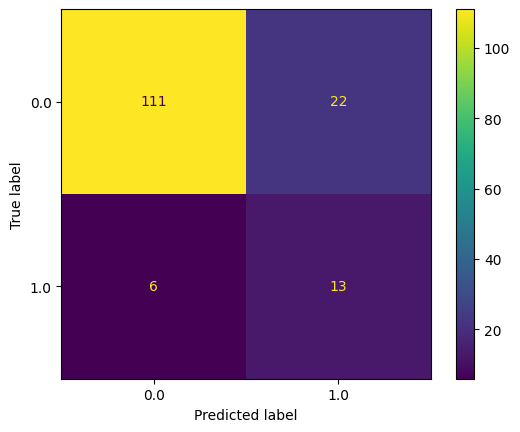

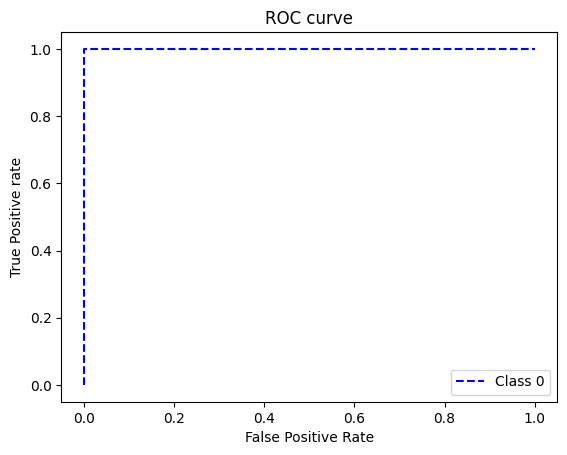

KNeighborsClassifier
              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91       133
         1.0       0.46      0.84      0.59        19

    accuracy                           0.86       152
   macro avg       0.72      0.85      0.75       152
weighted avg       0.91      0.86      0.87       152



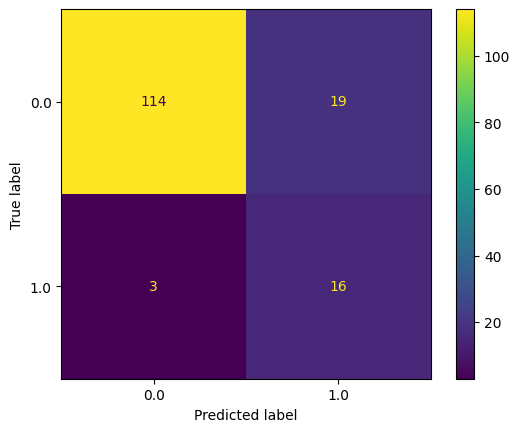

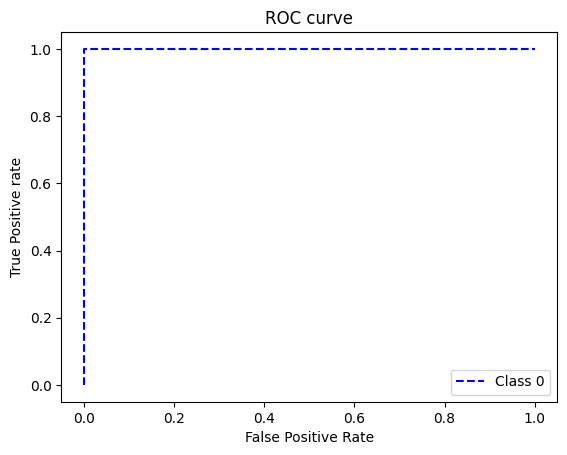

SVC
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.94       133
         1.0       0.55      0.89      0.68        19

    accuracy                           0.89       152
   macro avg       0.77      0.89      0.81       152
weighted avg       0.93      0.89      0.90       152



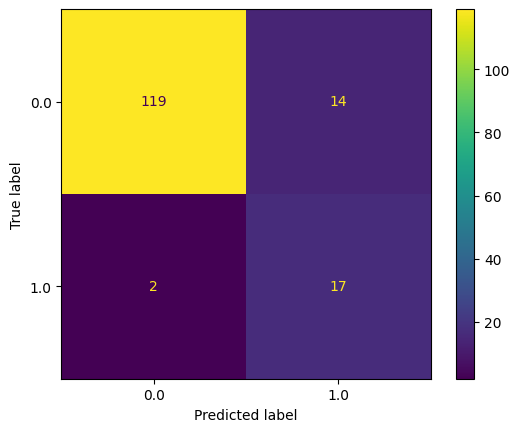

DecisionTreeClassifier
              precision    recall  f1-score   support

         0.0       0.92      0.78      0.85       133
         1.0       0.26      0.53      0.34        19

    accuracy                           0.75       152
   macro avg       0.59      0.65      0.60       152
weighted avg       0.84      0.75      0.78       152



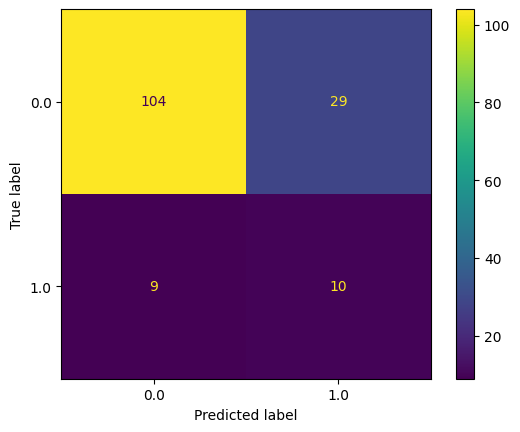

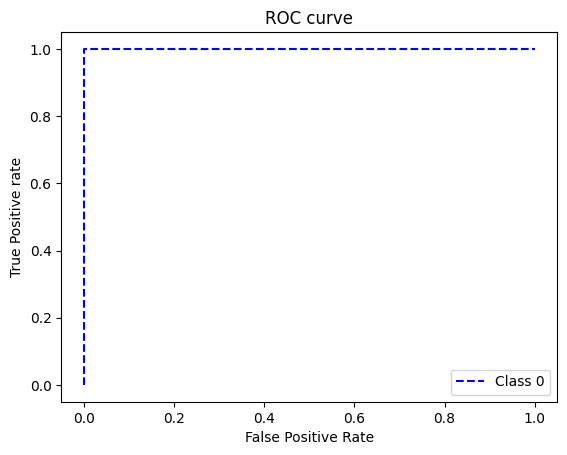

Bayes
              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91       133
         1.0       0.45      0.68      0.54        19

    accuracy                           0.86       152
   macro avg       0.70      0.78      0.73       152
weighted avg       0.89      0.86      0.87       152



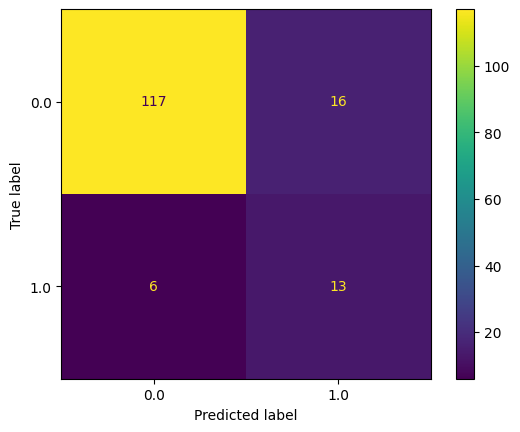

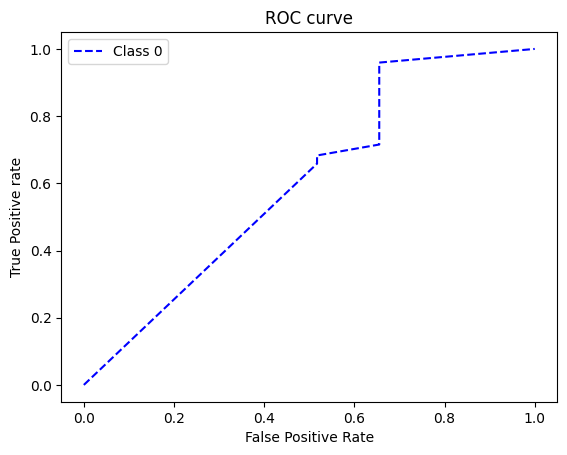

XGBClassifier
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91       133
         1.0       0.45      0.74      0.56        19

    accuracy                           0.86       152
   macro avg       0.71      0.80      0.74       152
weighted avg       0.90      0.86      0.87       152



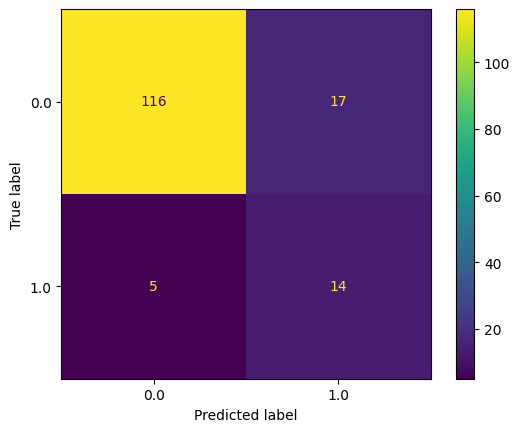

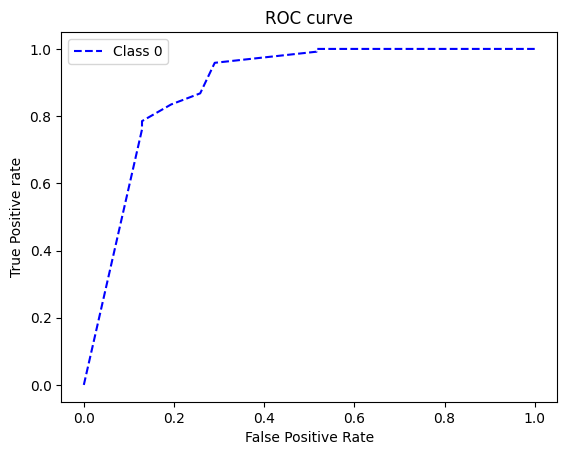

AdaBoostClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.78      0.86       133
         1.0       0.31      0.68      0.43        19

    accuracy                           0.77       152
   macro avg       0.63      0.73      0.64       152
weighted avg       0.87      0.77      0.80       152



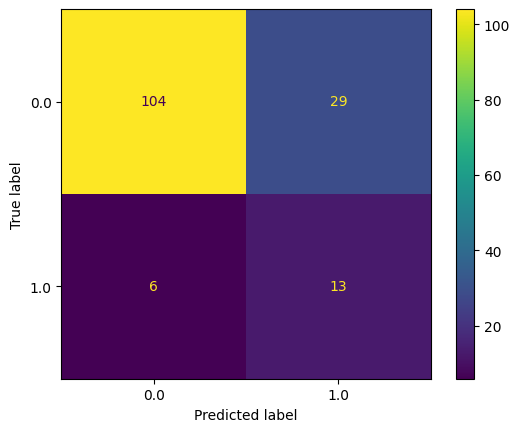

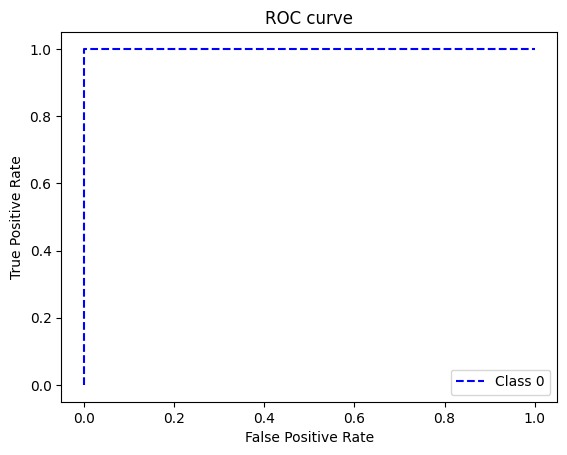

In [181]:
generate(X_train_ada, Y_train_ada, x_test, y_test)